In this notebook, I present the implementation of a small neural network architecture for the purpose of training a Go-playing bot. The architecture consists of convolutional and dense layers, designed to process the board state of a 19x19 Go game. The goal is to predict optimal moves based on the current game state by leveraging 100,000 board game positions that represent a diverse range of scenarios.

# Import Library

The baseline accuracy is .28% since, on a 19 x 19 board, the chance of making the correct play is only 1 in 361.

In [11]:
import matplotlib.pyplot as plt
from dlgo.data.parallel_processor import GoDataProcessor
from dlgo.encoders.oneplane import OnePlaneEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, ZeroPadding2D
from keras.callbacks import ModelCheckpoint

# NN Function

In [4]:
def small(input_shape):
    return [
        ZeroPadding2D(padding=(3, 3), input_shape=input_shape, data_format='channels_last'),
        Conv2D(48, (7, 7), data_format='channels_last'),
        Activation('relu'),

        ZeroPadding2D(padding=(2, 2), data_format='channels_last'),
        Conv2D(32, (5, 5), data_format='channels_last'),
        Activation('relu'),

        ZeroPadding2D(padding=(2, 2), data_format='channels_last'),
        Conv2D(32, (5, 5), data_format='channels_last'),
        Activation('relu'),

        ZeroPadding2D(padding=(2, 2), data_format='channels_last'),
        Conv2D(32, (5, 5), data_format='channels_last'),
        Activation('relu'),

        Flatten(),
        Dense(512),
        Activation('relu'),
    ]

# Creating Training and Test Generators

In [8]:
go_board_rows, go_board_cols = 19, 19
num_classes = go_board_rows * go_board_cols
num_games = 100000

encoder = OnePlaneEncoder((go_board_rows, go_board_cols)) 

processor = GoDataProcessor(encoder=encoder.name())

generator = processor.load_go_data('train', num_games, use_generator=True)
test_generator = processor.load_go_data('test', num_games, use_generator=True)

>>> Reading cached index page
KGS-2019_04-19-1255-.tar.gz 1255
KGS-2019_03-19-1478-.tar.gz 1478
KGS-2019_02-19-1412-.tar.gz 1412
KGS-2019_01-19-2095-.tar.gz 2095
KGS-2018_12-19-1992-.tar.gz 1992
KGS-2018_11-19-1879-.tar.gz 1879
KGS-2018_10-19-1209-.tar.gz 1209
KGS-2018_09-19-1587-.tar.gz 1587
KGS-2018_08-19-1447-.tar.gz 1447
KGS-2018_07-19-949-.tar.gz 949
KGS-2018_06-19-1002-.tar.gz 1002
KGS-2018_05-19-1590-.tar.gz 1590
KGS-2018_04-19-1612-.tar.gz 1612
KGS-2018_03-19-833-.tar.gz 833
KGS-2018_02-19-1167-.tar.gz 1167
KGS-2018_01-19-1526-.tar.gz 1526
KGS-2017_12-19-1488-.tar.gz 1488
KGS-2017_11-19-945-.tar.gz 945
KGS-2017_10-19-1351-.tar.gz 1351
KGS-2017_09-19-1353-.tar.gz 1353
KGS-2017_08-19-2205-.tar.gz 2205
KGS-2017_07-19-1191-.tar.gz 1191
KGS-2017_06-19-910-.tar.gz 910
KGS-2017_05-19-847-.tar.gz 847
KGS-2017_04-19-913-.tar.gz 913
KGS-2017_03-19-717-.tar.gz 717
KGS-2017_02-19-525-.tar.gz 525
KGS-2017_01-19-733-.tar.gz 733
KGS-2016_12-19-1208-.tar.gz 1208
KGS-2016_11-19-980-.tar.gz 980


In [9]:
input_shape = (encoder.num_planes, go_board_rows, go_board_cols)
network_layers = small(input_shape)
model = Sequential()
for layer in network_layers:
    model.add(layer)
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', 
metrics=['accuracy'])

In [10]:
epochs = 10
batch_size = 128

history = model.fit(
    x=generator.generate(batch_size, num_classes),
    epochs=epochs,
    steps_per_epoch=generator.get_num_samples() // batch_size,
    validation_data=test_generator.generate(batch_size, num_classes),
    validation_steps=test_generator.get_num_samples() // batch_size,
    callbacks=[ModelCheckpoint('../checkpoints/small_model_epoch_{epoch}.h5')],
)

score = model.evaluate(
    x=test_generator.generate(batch_size, num_classes),
    steps=test_generator.get_num_samples() // batch_size,
)

print(f'Test loss: \n{score[0]}')
print(f'Test accuracy: \n{score[1]}')

Epoch 1/10
222608/222608 [==============================] - 6701s 30ms/step - loss: 5.3838 - accuracy: 0.0229 - val_loss: 5.0057 - val_accuracy: 0.0391
Epoch 2/10
     3/222608 [..............................] - ETA: 1:36:27 - loss: 5.0765 - accuracy: 0.0286

C:\Users\Crypt\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


222608/222608 [==============================] - 6703s 30ms/step - loss: 4.7990 - accuracy: 0.0558 - val_loss: 4.6807 - val_accuracy: 0.0683
Epoch 3/10
222608/222608 [==============================] - 6627s 30ms/step - loss: 4.5423 - accuracy: 0.0880 - val_loss: 4.4665 - val_accuracy: 0.1006
Epoch 4/10
222608/222608 [==============================] - 6630s 30ms/step - loss: 4.3702 - accuracy: 0.1123 - val_loss: 4.3266 - val_accuracy: 0.1179
Epoch 5/10
222608/222608 [==============================] - 6671s 30ms/step - loss: 4.2480 - accuracy: 0.1279 - val_loss: 4.2340 - val_accuracy: 0.1302
Epoch 6/10
222608/222608 [==============================] - 6714s 30ms/step - loss: 4.1613 - accuracy: 0.1405 - val_loss: 4.1633 - val_accuracy: 0.1400
Epoch 7/10
222608/222608 [==============================] - 6821s 31ms/step - loss: 4.1039 - accuracy: 0.1479 - val_loss: 4.1166 - val_accuracy: 0.1448
Epoch 8/10
222608/222608 [==============================] - 7045s 32ms/step - loss: 4.0277 - accura

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_4 (ZeroPadd  (None, 7, 25, 19)         0         
 ing2D)                                                          
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 19, 48)         44736     
                                                                 
 activation_5 (Activation)   (None, 1, 19, 48)         0         
                                                                 
 zero_padding2d_5 (ZeroPadd  (None, 5, 23, 48)         0         
 ing2D)                                                          
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 19, 32)         38432     
                                                                 
 activation_6 (Activation)   (None, 1, 19, 32)        

# Plot Results

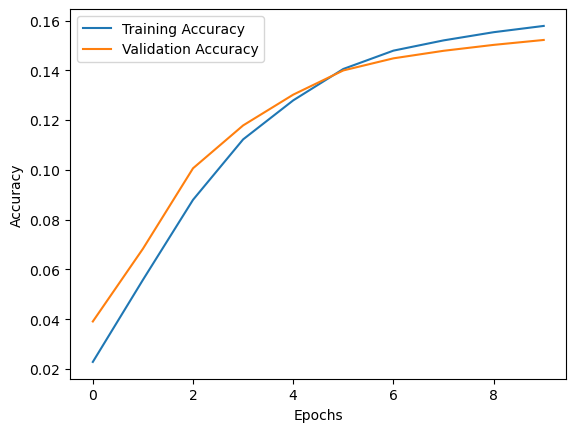

In [13]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_plot.png');